# Winter School 2024 - EDA Tutorial

This notebook highlights an exploratory data analysis using the example of the Titanic data set
(https://www.kaggle.com/competitions/titanic/data).

Authors: Christopher Katins, Mario Sänger, Christopher Lazik, Thomas Kosch
Credits to Patrick Schäfer (HU Berlin)

------------

Contents of the Notebook:

#### Part 1: Data Description and Visualization:

1. Analyzing features and their distribution.
2. Finding relations or trends between features.

#### Part 2: Feature Engineering and Data Cleaning:

1. Adding features.
2. Removing features.
3. Converting features into suitable form for modeling.

#### Part 3: Predictive Modeling

1. Running a simple classification algorithm.

--------------------


# Part 1: Data Description and Visualization

Setup the environment and install the required packages

In [1]:
!python -m venv env_eda_titanic

In [2]:
!source env_eda_titanic/bin/activate

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 131.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/27.1 MB 105.1 kB/s eta 0:03:01

Import used packages and used classes / functions

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv("data/titanic_train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Basic Structure

Use .info() to get brief information about the dataframe

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Types of Features

- Nominal Features:
  - Name: Full name
  - Sex: Sex of the passenger
  - Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
  - Ticket: Ticket number
  - Cabin: Cabin number
  - Survived: Survival (0 = No, 1 = Yes)

- Ordinal Features:
  - PClass: Ticket class as a proxy for socio-economic status (1 = 1st, 2 = 2nd, 3 = 3rd)

- Continuous Feature:
  - Age: Passenger age
  - Fare: Passenger fare

- Discrete Features:
  - SibSp: Number of siblings (brother, sister, stepbrother, stepsister)) / spouses (husband, wife) aboard the Titanic
  - Parch: Number of parents (mother, father) / children (daughter, son, stepdaughter, stepson)*

*Some children travelled only with a nanny, therefore parch=0 for them.

In [6]:
# Get number of unique values per column
data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### Null Values and Summary Statistics

In [8]:
# Describe basic statistics of the numerical attributes
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
# Describe basic statistics of the non-numerical attributes
data.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Missing Values



In [13]:
# Checking for total number of null values for each column
data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

=> The `Age`, `Cabin` and `Embarked` have null values. we will try to infer them from the data.

In [14]:
# Checking for duplicates in the data set
data.duplicated().any()

False

=> No duplicated rows

### Survival rates

Let's first inspect the survival rates of the passengers

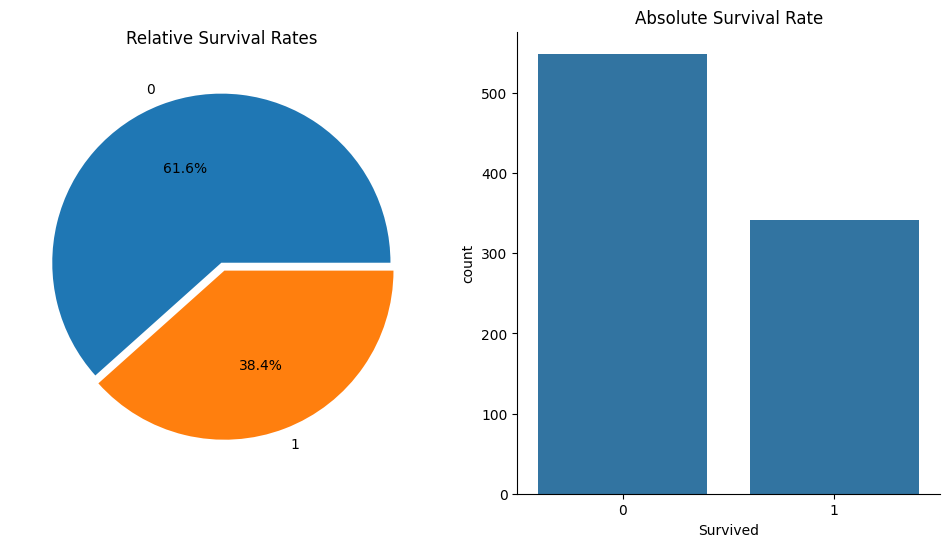

In [20]:
# Create a figure with two sub-plots
f,ax=plt.subplots(1,2,figsize=(12,6))

# Pie plot for relative rates
data["Survived"].value_counts().plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('Relative Survival Rates')
ax[0].set_ylabel('')

# Bar plot for absolute rates
sns.countplot(data, x="Survived", ax=ax[1])
ax[1].set_title("Absolute Survival Rate")
sns.despine()

**Observation:**
- Out of 891 passengers in training set, only around 350 survived
- That is: 38.4% survived

We will  dig down deeper to get better insights and see which features of the passengers increased the chance of survival

# Key Question: What influenced the chance of survival?

### Factor Sex

We will first build a crosstab between Sex and Survival Rates.

In [22]:
pd.crosstab(data["Sex"],data["Survived"],margins=True)  \
    .style.background_gradient(cmap='Blues')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


We will next use a histogram to show the relation

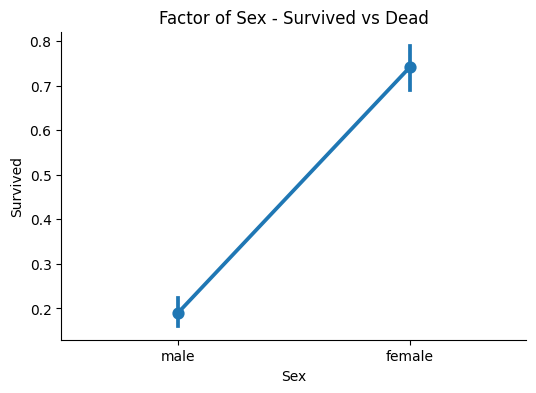

In [24]:
f,ax=plt.subplots(1,1,figsize=(6,4))

ax = sns.pointplot(data, x='Sex', y='Survived', ax=ax)
ax.set_title('Factor of Sex - Survived vs Dead')
sns.despine()
plt.show()

**Observations:**

=> Concerning female passengers: ~ 3/4 of the passengers survived
=> For male passengers it's inverse: ~ only 1/5 of the passengers survived
=> We can clearly see that female passengers had a much higher rate of survival.

### Factor PClass

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Survived,0,1,All
Pclass,,,
1,0.089787,0.152637,0.242424
2,0.108866,0.097643,0.206510
3,0.417508,0.133558,0.551066
All,0.616162,0.383838,1.000000


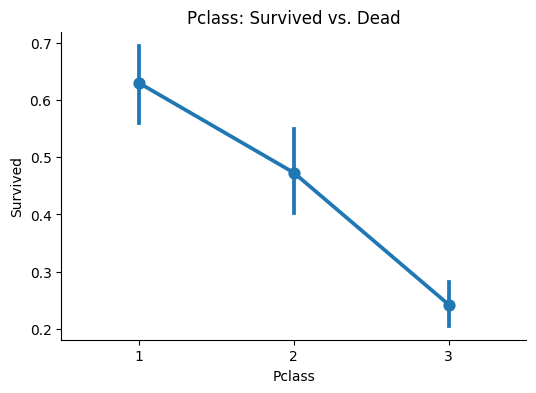

In [27]:
# Build a cross table for pclass and survived
ct = pd.crosstab(data["Pclass"],data["Survived"],margins=True) \
    .style.background_gradient(cmap='Blues')
display(ct)

# Get the table with normalized values
ct = pd.crosstab(data["Pclass"],data["Survived"],margins=True, normalize=True) \
    .style.background_gradient(cmap='Blues')
display(ct)

# Plot the values
_,ax = plt.subplots(1,1,figsize=(6,4))
sns.pointplot(data, x="Pclass", y="Survived", ax=ax)
ax.set_title("Pclass: Survived vs. Dead")
sns.despine()

**Observations:**
=> We can clearly see that passengers of class 1 were given a high priority while rescue.

### Sex AND Pclass

Now let's look on the joint impact of Sex and Pclass

In [29]:
pd.crosstab([data["Sex"],data["Survived"]],data["Pclass"],margins=True) \
    .style.background_gradient(cmap='Blues')

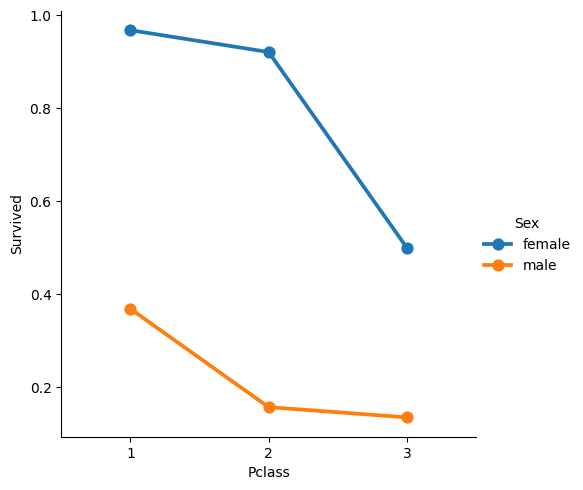

In [83]:
sns.catplot(data, x="Pclass", y="Survived", hue="Sex", kind="point")
sns.despine()

**Observations:**
=> The chances of survival were highest, if you were female and in the first passenger class.
    

### Age

Let's inspect the age of the passengers ...

In [35]:
print('Oldest Passenger was:',data['Age'].max(),'Years')
print('Youngest Passenger was:',data['Age'].min(),'Years')

Oldest Passenger was: 80.0 Years
Youngest Passenger was: 0.42 Years


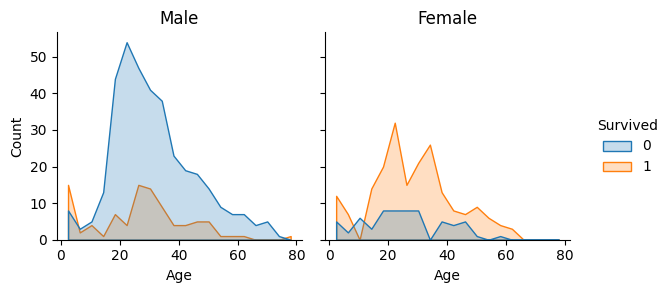

In [49]:
fg = sns.displot(data, x="Age", hue="Survived", col="Sex", element="poly", height=3)
fg.axes_dict["male"].set_title("Male")
_ = fg.axes_dict["female"].set_title("Female")

**Observations:**
    
1. Survival rates for passenegers below age 10 is increased
2. Survival chances for passenegers aged 20-50 from Pclass 1 is highest, and even better for women.
3. The Women and Child first policy thus holds true

### Filling Missing Values

## Filling Age

As we had seen earlier, the Age feature has 177 null values.

The Name feature has a salutation like Mr or Mrs. Thus we may use it to guess the age of respective groups.

In [51]:
data[["Name"]].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


We are using a Regex for extracting the salutation / initial of the persons. It returns strings that contain A-Z or a-z and are followed by a punctuation "." (dot)

In [60]:
data["Initial"] = data["Name"].str.extract('([A-Za-z]+)\.')
data[["Initial"]].head()

,Initial
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


### Checking Frequency of Initial

In [55]:
pd.crosstab(data["Initial"],data["Sex"]).T \
    .style.background_gradient(cmap='Blues')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [57]:
data.groupby("Initial")[["Age"]].mean()

,Age
Initial,
Capt,70.000000
Col,58.000000
Countess,33.000000
Don,40.000000
Dr,42.000000
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,4.574167


**Observations:**
=> There are some misspelled initials like Mlle or Mme that stand for Miss

In [62]:
data["Initial"].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)

In [63]:
data.groupby('Initial')[['Age']].mean()

,Age
Initial,
Master,4.574167
Miss,21.860000
Mr,32.739609
Mrs,35.981818
Other,45.888889


**Observations:**
=> Master can be matched to male children. Miss is less distinct.

## Filling Missing Ages by Intial-Averages

In [64]:
data[data["Age"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Mr
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Mr
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,Mr


In [68]:
data["Age"].fillna(data.groupby("Initial")["Age"].transform("mean"), inplace=True)

In [69]:
data.Age.isnull().any()

False

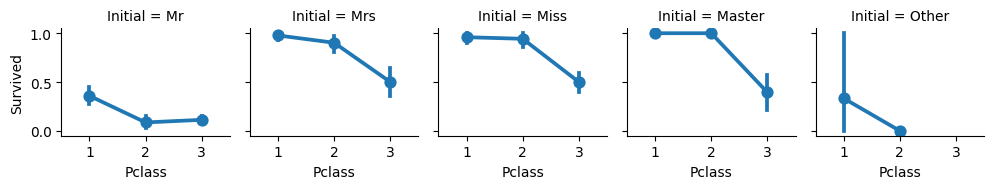

In [72]:
# Inspect the survival rates per initial and Pclass
sns.catplot(data, x="Pclass", y="Survived", col="Initial", kind="point", height=2)
sns.despine()

**Observation:**
=> The Women and Child first policy thus holds true

### Embarked

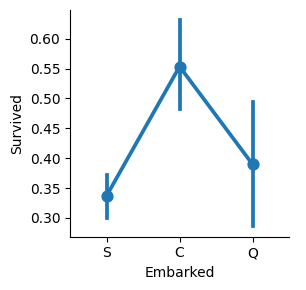

In [85]:
sns.catplot(data, x="Embarked", y="Survived", kind="point", height=3);

**Observations:**
=> The chances for survival for Port C (Cherbourg) is highest around 0.55 while it is lowest for S (Southampton).

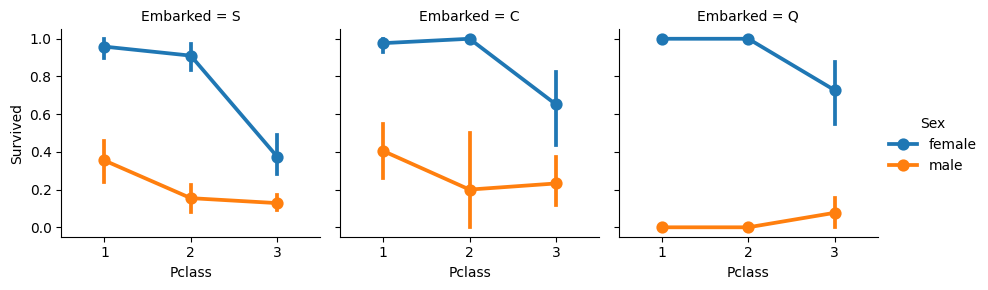

In [86]:
sns.catplot(data, x="Pclass",y="Survived", kind="point", hue="Sex", col="Embarked", height=3);

**Observations:**

- The survival rates are ~1 for women from Pclass 1 and Pclass 2 irrespective of the port
- Port S is worst for Pclass 3
- Port Q is worst for Men

# Filling Emarked NaN

There are two missing values for `Embarked`


In [87]:
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [89]:
# Let's check which is the port with the highest number of entering passengers
data["Embarked"].mode()

0    S
Name: Embarked, dtype: object

In [90]:
data["Embarked"].value_counts(normalize=True)

Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64

As we saw that most passengers boarded from Port S, we replace NaN with S.

In [91]:
data["Embarked"].fillna("S", inplace=True)
data["Embarked"].isnull().any()

False

### SibSip

This feature represents whether a person is alone or with his family members.

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife

In [92]:
pd.crosstab(data["SibSp"], data["Survived"], normalize=True) \
    .style.background_gradient(cmap='Blues')

Survived,0,1
SibSp,,
0,0.446689,0.235690
1,0.108866,0.125701
2,0.016835,0.014590
3,0.013468,0.004489
4,0.016835,0.003367
5,0.005612,0.000000
8,0.007856,0.000000


In [93]:
pd.crosstab(data["SibSp"],data["Pclass"], normalize=True) \
    .style.background_gradient(cmap='Blues')

Pclass,1,2,3
SibSp,,,
0,0.153760,0.134680,0.393939
1,0.079686,0.061728,0.093154
2,0.005612,0.008979,0.016835
3,0.003367,0.001122,0.013468
4,0.000000,0.000000,0.020202
5,0.000000,0.000000,0.005612
8,0.000000,0.000000,0.007856


Text(0.5, 1.0, 'SibSp vs Survived')

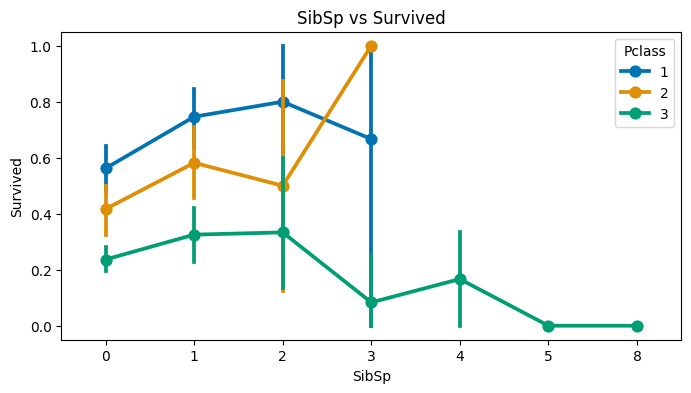

In [95]:
f,ax=plt.subplots(figsize=(8,4))
sns.pointplot(data, x="SibSp", y="Survived", hue="Pclass", palette="colorblind", ax=ax)
ax.set_title("SibSp vs Survived")

**Observations:**
- Plcass 1 and 2 had highest chances of survival
- Families with 3 Members had highest chances of survival
- Families >3 were only in Pclass 3
- Survival for families with >5 members is 0%. 


### Fare

In [96]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


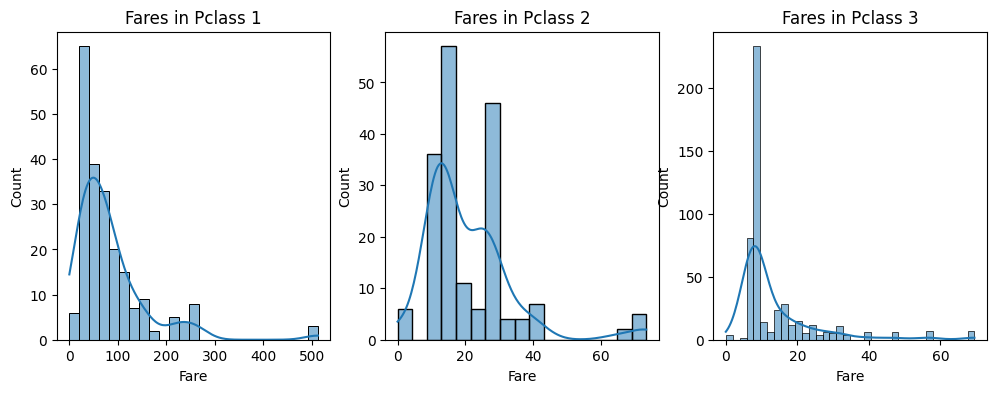

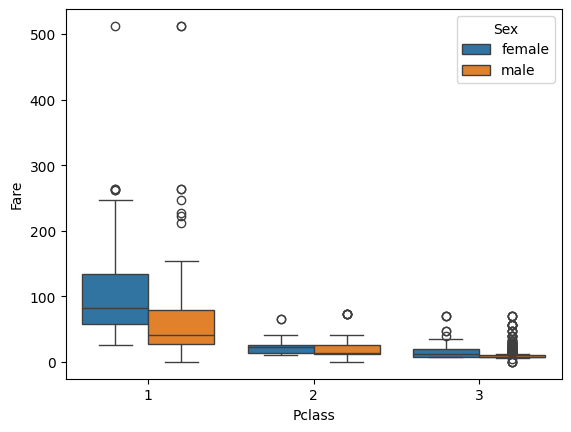

In [97]:
f,ax=plt.subplots(1,3,figsize=(12,4))

sns.histplot(x=data[data['Pclass']==1].Fare,kde=True,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

sns.histplot(x=data[data['Pclass']==2].Fare,kde=True,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')

sns.histplot(x=data[data['Pclass']==3].Fare,kde=True,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')

plt.show()
sns.boxplot(x="Pclass", y="Fare", hue="Sex", data=data);

**Observation:**
=> There seems to be a large spread in distributions of fares. Some outliers.

### Log transformed Data

Let's see how the distributions look if we log transform the data

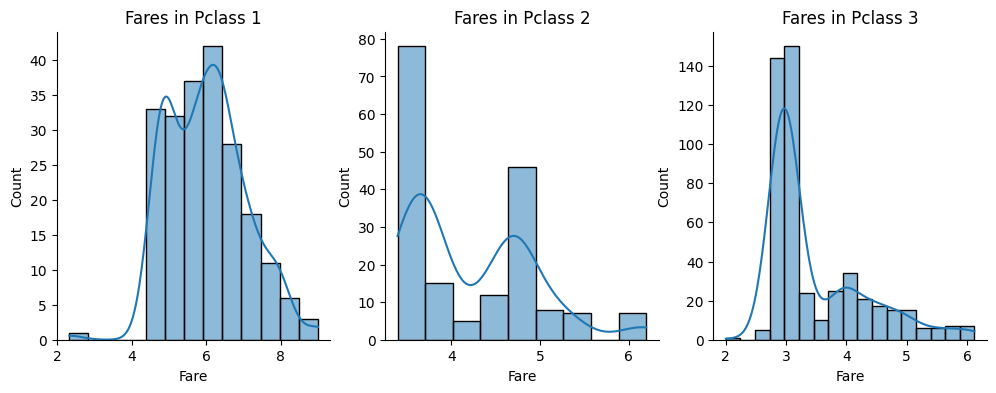

In [100]:
def get_log_fare(data, pclass):
    fare = data[data['Pclass']==pclass]["Fare"]
    return np.log2(fare[fare>0])

f,ax=plt.subplots(1,3,figsize=(12,4))
sns.histplot(x=get_log_fare(data, 1), kde=True, ax=ax[0])
sns.despine()
ax[0].set_title('Fares in Pclass 1')

sns.histplot(x=get_log_fare(data, 2), kde=True, ax=ax[1])
sns.despine()
ax[1].set_title('Fares in Pclass 2')

sns.histplot(x=get_log_fare(data, 3), kde=True, ax=ax[2])
sns.despine()
_ = ax[2].set_title('Fares in Pclass 3')

**Observation:**
=> Still difficult to interpret the observations due to high variance :-(

## QQ-Plot - Test for Normality

Quantile-quantile plots (QQ-Plots) are a graphical tool used to assess whether a set of data follows a particular probability distribution (e.g. normal distribution)

In [101]:
import statsmodels.api as sm
ax = sm.qqplot(get_log_fare(data, 1), fit=True, line="45");
ax.suptitle("Plcass 1")
sm.qqplot(get_log_fare(data, 2), fit=True, line="45");
sm.qqplot(get_log_fare(data, 3), fit=True, line="45");

ModuleNotFoundError: No module named 'statsmodels'

**Observation**: No signs of normal distribution, even for log-transformed data

# Part 2: Feature Engineering and Data Cleaning

# Family_Size and Alone

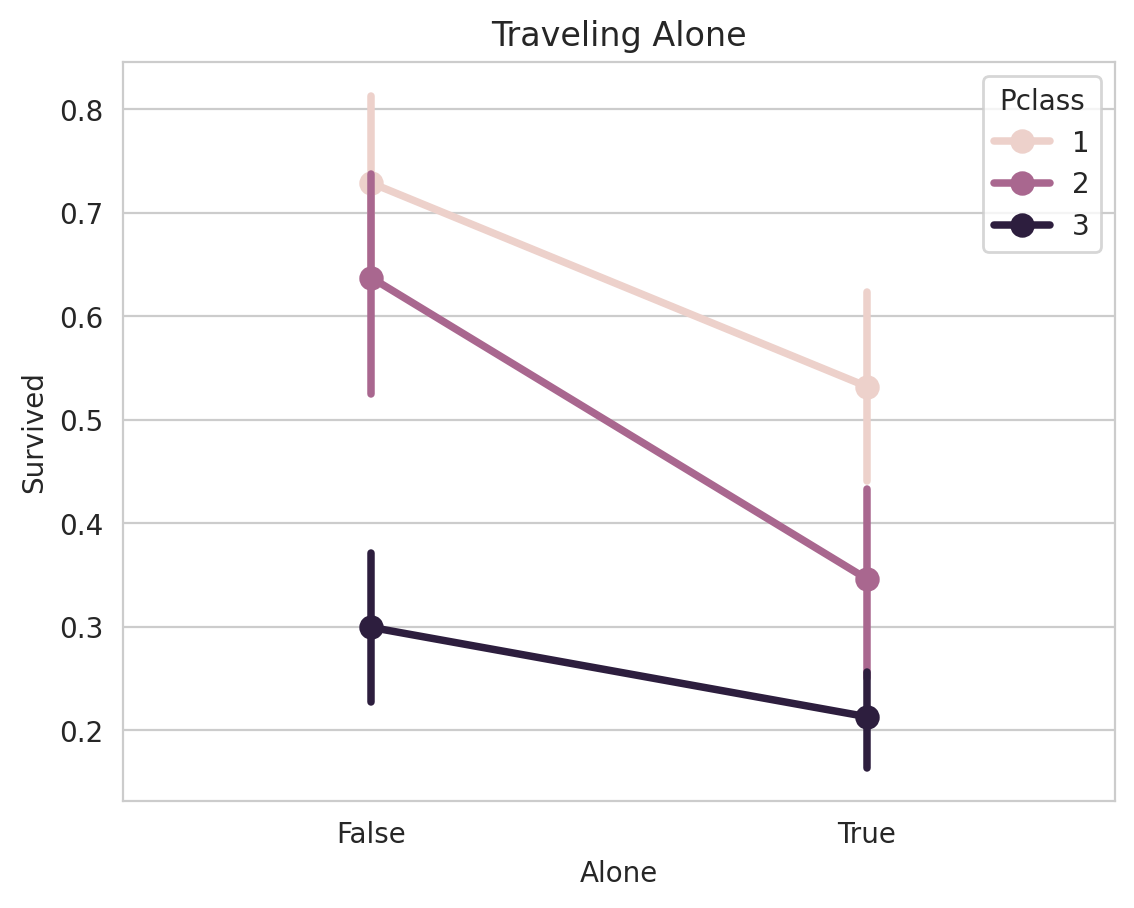

In [55]:
data['Family_Size'] = 0
data['Family_Size'] = data['Parch']+data['SibSp']
data['Alone'] = data.Family_Size==0

ax = sns.pointplot(x='Alone',y='Survived', hue="Pclass", data=data)
ax.set_title("Traveling Alone");

**Observation** If you were alone then chances for survival is very low. 


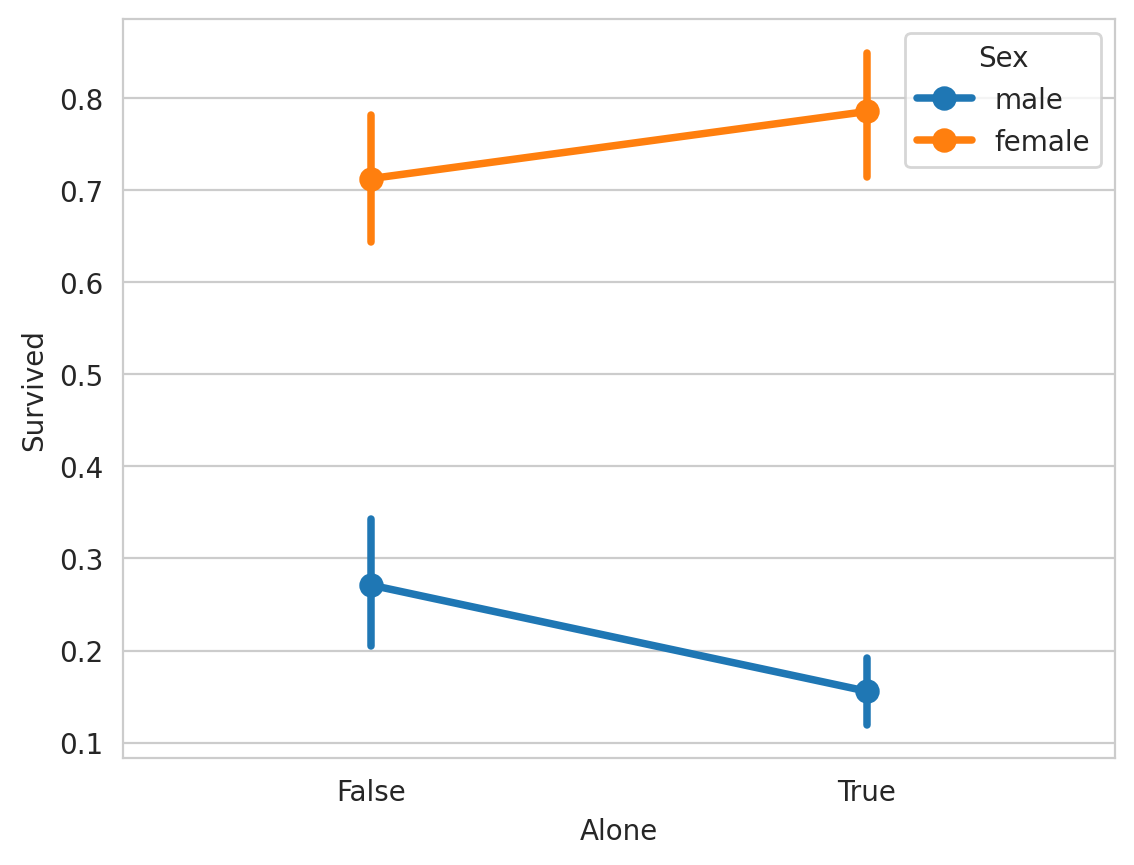

In [56]:
ax = sns.pointplot(x='Alone',y='Survived',data=data, hue='Sex')

Observation: chances of females, who are alone, are higher than those with family.

# Outlier Handling - Binning Fares

In [57]:
data['Fare_Range'] = pd.qcut(data['Fare'],4,labels=["Small","Medium","Large", "Rich"])
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='Blues')

/tmp/ipykernel_123764/1835988229.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='Blues')


,Survived
Fare_Range,
Small,0.197309
Medium,0.303571
Large,0.454955
Rich,0.581081


**Observation:** We observe that as the fare increases, the chances of survival increases.


# Encoding Categorical Values

In [58]:
data_numerical = pd.get_dummies(data, columns=['Sex'], prefix='is')
data_numerical = pd.get_dummies(data_numerical, columns=['Embarked'], prefix='is')
data_numerical = pd.get_dummies(data_numerical, columns=['Initial'], prefix='is')
data_numerical = pd.get_dummies(data_numerical, columns=['Fare_Range'], prefix='is')

# Correlation Between The Numerical Features

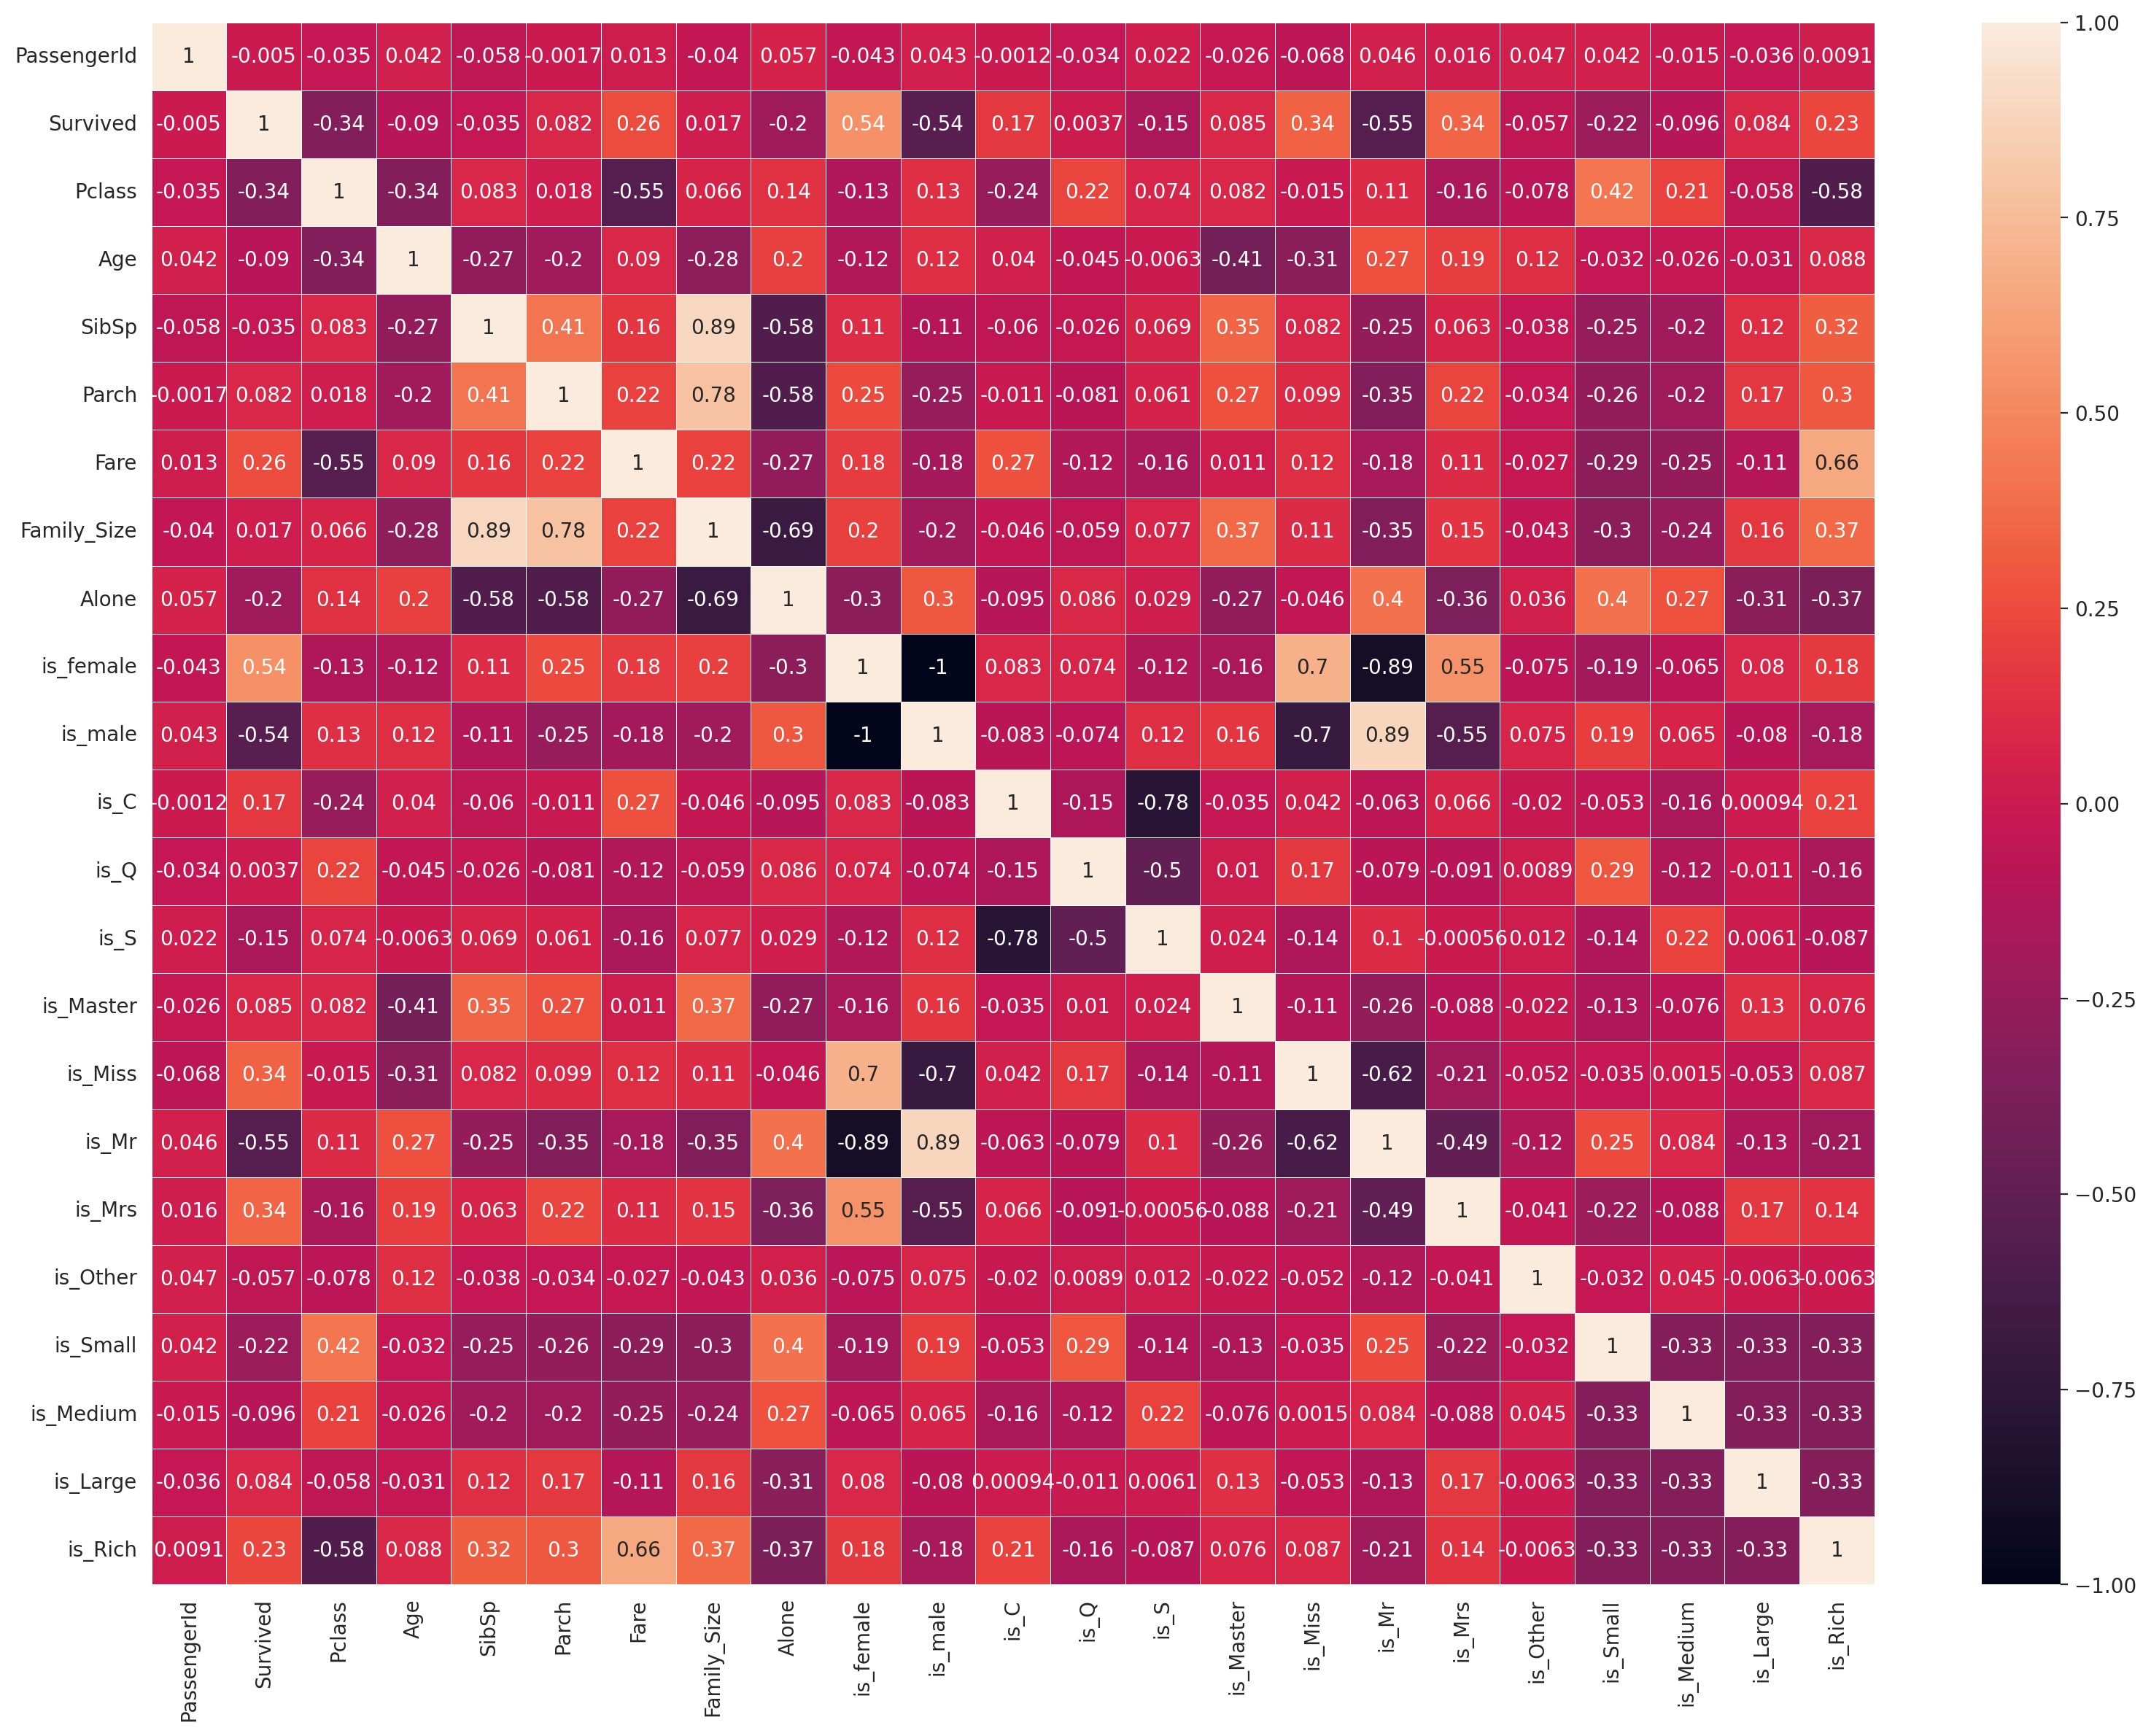

In [59]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(data_numerical.corr(numeric_only=True), annot=True, linewidths=0.2, ax=ax)
plt.tight_layout()
plt.show()

There is high correlation between `survived` and `Pclass`, `Fare`, `is_female`, `is_male` `is_S`, `is_C`, `is_Mr`, `is_Mrs`, `is_Miss`, `alone`, `is_rich`

# Observations in a Nutshell for all features:

- Sex: 
    - The chance of survival for women is high as compared to men
- Pclass: 
    - Fares varied significantly with few passengers (<1%) paying as high as $512
    - The more you pay, the better chances of survival
    - The survival rate for Pclass3 is very low
- Age: 
    - Children between 5-10 years do have a high chance of survival
- Embarked: 
    - The chances of survival at C and S were high for lower passenger classes
- Parch+SibSp: 
    - Having a small family  gives a greater chance of than traveling alone (as male) or having a large family travelling with you
    - Females travel best alone

# Part 3: Predictive Modeling

- We have gained insights from the EDA 
- Using this insights, we cannot accurately predict whether a passenger will survive or not
- So we may use a classification algorithm to predict whether the Passenger will survive


In [60]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# display(data_numerical.head())
train_y = data_numerical['Survived']
train_X = data_numerical.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])

# Scaled data has zero mean and unit variance:
# deprecated:
# train_X = StandardScaler().fit_transform(train_X)
# clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True).fit(train_X, train_y)
# score = clf.score(train_X, train_y)
# print ("Accuracy of Model: ", score)

# Train Regression model
clf = make_pipeline(StandardScaler(), 
                    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))).fit(train_X, train_y)
score = clf.score(train_X, train_y)

print ("Accuracy of Model: ", score)

Accuracy of Model:  0.8327721661054994
